# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Filip Michalsky and Ryan Janssen

Enrollment Status (109A, 121A, 209A, or E109A): 209A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
from sklearn.metrics import accuracy_score


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

In [4]:
# First, divide into x and y sets, and normalize both predictor variables against training set data shape
x_train = data_train.copy(deep=True).drop('Diagnosis', axis = 1)
y_train = data_train.copy(deep=True)['Diagnosis']
x_test = data_test.copy(deep=True).drop('Diagnosis', axis = 1)
y_test = data_test.copy(deep=True)['Diagnosis']

x_test_norm = (x_test - x_train.mean())/x_train.std()
x_train_norm = (x_train - x_train.mean())/x_train.std()

(<matplotlib.legend.Legend at 0x116c9ce80>,
 <matplotlib.text.Text at 0x116c5a908>)

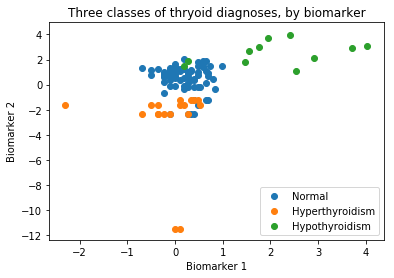

In [5]:
# Question 1.1:

# Plot the scatter plot on the non-normalized values
plt.scatter(x_train['Biomarker 1'][y_train == 1], x_train['Biomarker 2'][y_train == 1], label = "Normal")
plt.scatter(x_train['Biomarker 1'][y_train == 2], x_train['Biomarker 2'][y_train == 2], label = "Hyperthyroidism")
plt.scatter(x_train['Biomarker 1'][y_train == 3], x_train['Biomarker 2'][y_train == 3], label = "Hypothyroidism")
plt.xlabel("Biomarker 1"), plt.ylabel("Biomarker 2")
plt.legend(loc="lower right"), plt.title("Three classes of thryoid diagnoses, by biomarker")

In [6]:
# Question 1.3

# Fit the MLR and OVR model, respectively
mlr_model = LogisticRegressionCV(multi_class='multinomial', penalty = 'l2')
mlr_model.fit(x_train_norm, y_train)
ovr_model = LogisticRegressionCV(multi_class='ovr', penalty = 'l2')
ovr_model.fit(x_train_norm, y_train)

# Output respective model accuracies
print("Multinomial regression train accuracy score=",mlr_model.score(x_train_norm, y_train))
print("Multinomial regression test accuracy score=",mlr_model.score(x_test_norm, y_test))
print("")
print("One vs. Rest regression train accuracy score=",ovr_model.score(x_train_norm, y_train))
print("One vs. Rest regression test accuracy score=",ovr_model.score(x_test_norm, y_test))

Multinomial regression train accuracy score= 0.892156862745
Multinomial regression test accuracy score= 0.884955752212

One vs. Rest regression train accuracy score= 0.872549019608
One vs. Rest regression test accuracy score= 0.867256637168


In [8]:
# Question 1.4

# Fit the MLR model since its performance was slightly better
# (note that CV is inherent in the LogisticRegressionCV function)
quad_MLR_pipe = Pipeline([ ('poly', PolynomialFeatures(degree = 2, interaction_only=False)), 
                           ('mlr', LogisticRegressionCV(multi_class='multinomial', penalty = 'l2')
                           )])
quad_MLR_pipe.fit(x_train_norm, y_train)

# Fit the LDA model
LDA_model = LinearDiscriminantAnalysis(solver='eigen')
LDA_param_grid = [{'shrinkage': np.arange(0,1,0.1)}]
LDA_grid = GridSearchCV(LDA_model, param_grid=LDA_param_grid, cv = 10)
LDA_grid.fit(x_train_norm, y_train)

# Fit the QDA model
QDA_model = QuadraticDiscriminantAnalysis()
QDA_param_grid = [{'reg_param': np.logspace(-7, 7, 1)}]
QDA_grid = GridSearchCV(QDA_model, param_grid=QDA_param_grid, cv = 10)
QDA_grid.fit(x_train_norm, y_train)

# Fit the KNN Model
KNN_pipe = Pipeline([('knn', KNeighborsClassifier()), 
                           ])
KNN_param_grid = [{'knn__n_neighbors': [2, 3, 5, 7, 10, 15, 20, 25]}]
KNN_grid = GridSearchCV(KNN_pipe, param_grid=KNN_param_grid, cv = 10)
KNN_grid.fit(x_train_norm, y_train)


print("Quadratic MLR:")
print("Train score =", quad_MLR_pipe.score(x_train_norm, y_train))
print("Test score =", quad_MLR_pipe.score(x_test_norm, y_test))
print("")
print("LDA:")
print("Train score =", LDA_grid.score(x_train_norm, y_train))
print("Test score =", LDA_grid.score(x_test_norm, y_test))
print("")
print("QDA:")
print("Train score =", QDA_grid.score(x_train_norm, y_train))
print("Test score =", QDA_grid.score(x_test_norm, y_test))
print("")
print("KNN:")
print("Train score =", KNN_grid.score(x_train_norm, y_train))
print("Test score =", KNN_grid.score(x_test_norm, y_test))

Quadratic MLR:
Train score = 0.892156862745
Test score = 0.902654867257

LDA:
Train score = 0.813725490196
Test score = 0.814159292035

QDA:
Train score = 0.872549019608
Test score = 0.849557522124

KNN:
Train score = 0.941176470588
Test score = 0.884955752212


## Question 1:  Answers

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?<br>
** The decision boundary is plotted above.  It appears that the data CANNOT be well-separated by a linear classifier.**<br>
** We can see, for example, that the boundary between Normal and Hyperthyroidism is complex - the normal cases tend to "wrap around" the Hyperthyroidism cases in a non-linear way.  **<br>
** It's also interesting to note that the respective data do not appear to be particularily normal shaped. **<br><br>
2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).<br>
**In the multinomial logistic regression, a single n-ary classification fit is performed.  This fit is selected to minimize the loss over the entire set.**<br><br>
** In a One-vs-Rest (OvR) logistic regression, a separate (independent) regression is performed for each of the labels.  So in this case, for example, the function will complete a binary logistic regression for {Hyperthyroidism} vs. {Normal or Hypothyroidism}, one for {Hypothyroidism} vs. {Normal or Hyperthyroidism}, and one for {Normal} vs. {Hyperthyroidism or Hypothyroidism} and compile the three into a single regression.**<br><br>
3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?<br>
** The accuracy of each respective method is:**<br>
*Multinomial regression train accuracy score= 0.892156862745*<br>
*Multinomial regression test accuracy score= 0.884955752212*<br>
*One vs. Rest regression train accuracy score= 0.872549019608*<br>
*One vs. Rest regression test accuracy score= 0.867256637168*<br><br>
** As we can see, the multinomial regression was more accurate for both the train and test sets (although the difference is not huge).  This is speculation, but we are hypothesizing mutinomial regression may work better here because there are no areas where the data has a "3-way" overlap of all classes.**<br><br>
4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. <br><br>
** The accuracy of each respective model is:**<br>
*Quadratic MLR:*<br>
Train score = 0.892156862745<br>
Test score = 0.902654867257<br><br>
*LDA:*<br>
Train score = 0.813725490196<br>
Test score = 0.814159292035<br><br>
*QDA:*<br>
Train score = 0.872549019608<br>
Test score = 0.849557522124<br><br>
*KNN:*<br>
Train score = 0.941176470588<br>
Test score = 0.884955752212<br><br>

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms?<br>
** Yes, the inclusion of quadratic terms improves our MLR test accuracy from 0.885 to 0.903.  This is as expected since we have concluded the data has a non-linear boundary.**<br><br>
** In fact, we can generally see the nonlinear models outperform their linear equivalents (Quadratic MLR > Linear MLR, and QDA > LDA).  KNN (another non-linear model) overfits but also generally performs well.**

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [37]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

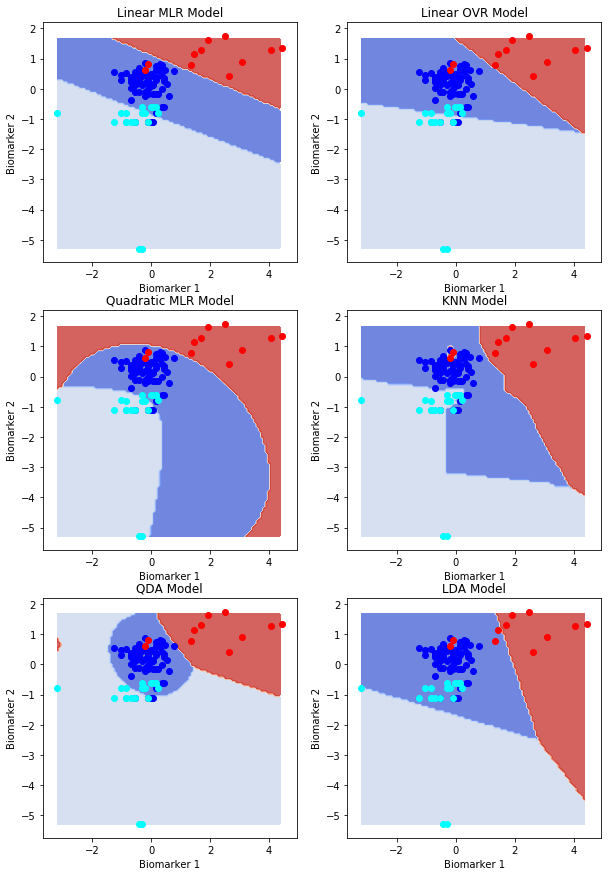

In [38]:
# Question 2.1
# Add the respective plots for each model calculated above
fig, ax_arr = plt.subplots(3,2, figsize = (10,15))

plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), mlr_model, "Linear MLR Model", ax_arr[0,0])
plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), ovr_model, "Linear OVR Model", ax_arr[0,1])
plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), quad_MLR_pipe, "Quadratic MLR Model", ax_arr[1,0])
plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), KNN_grid, "KNN Model", ax_arr[1,1])
plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), QDA_grid, "QDA Model", ax_arr[2,0])
plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), LDA_grid, "LDA Model", ax_arr[2,1])

## Question 2: Answers
1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.<br>
** Each decision boundary is plotted directly above. **<br><br>

2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.<br>
** *OvR vs. multinomial logistic regression:* **<br>
** We can see that both boundaries are linear, as expected.  They are actually quite similar except MLR assumes the boundaries are quite parallel, whereas the OvR boundary has a point where all three states converge at roughly (4,-1).  As a result, the MLR fits the data slightly better, because the decision boundary between Normal and Hyperthyroidism is better aligned. ** <br><br>
** *LDA vs. linear logistic regression:* **<br>
** Both boundaries are clearly linear here.  However, here the linear regression clearly outperforms the LDA, which misclassifies due to the unsatisfied requirement that the data must be normal.  Hyperthyroidism has several outliers and is not normal at all, but LDA treats the data as if it's normal.  This results in almost al Hyperthyroidism cases being classified as Normal.   ** <br><br>
** *QDA vs. quadratic logistic regression:* **<br>
** Both curves are non-linear, as expected.  However, the quadratic linear model is able to fit around the data while QDA is restricted to keeping a fairly oval-shaped boundary around the Normal cases.  Because of the shape of the data is closer to the QLR's quadratic shape, rather than the QDA's oval shape, QLR appears to be a better fit for the data here.  This is again likely because QDA requires a normal-shaped dataset (which will take the shape of a skewed/rotated oval) and our set here is not normal.  **<br><br>
** *Other: KNN* **<br>
** Of note is that the KNN boundary here seems to strike an effective balance of capturing the nonlinear shape of the data while only slightly overfitting.  Its boundary is the closest fit to the shape of the three classifications, and has the potential to be the superior model with a small amount of smoothing.**

## Question 3

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


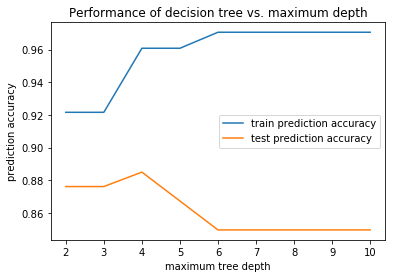

In [39]:
# Question 3.1
train_scores = []
test_scores = []
depth_min, depth_max = 2, 10
depth_range = range(depth_min, depth_max + 1)

for this_depth in depth_range:
    dec_tree = DecisionTreeClassifier(criterion = 'gini', max_depth = this_depth)
    dec_tree.fit(x_train_norm, y_train)
    train_scores.append(dec_tree.score(x_train_norm, y_train))
    test_scores.append(dec_tree.score(x_test_norm, y_test))
    
plt.plot(depth_range, train_scores, label="train prediction accuracy")
plt.plot(depth_range, test_scores, label="test prediction accuracy")
plt.title("Performance of decision tree vs. maximum depth")
plt.xlabel("maximum tree depth"), plt.ylabel("prediction accuracy")
plt.legend()

In [40]:
# Question 3.2
depth_min, depth_max = 2, 10
max_depths = range(depth_min, depth_max+1)

dec_tree = GridSearchCV(DecisionTreeClassifier(),
                        dict(max_depth = max_depths),
                        cv = 5,
                        return_train_score = True)
dec_tree.fit(x_train_norm, y_train)
print(dec_tree.best_estimator_.max_depth)
print(dec_tree.cv_results_['mean_test_score'])

2
[ 0.91176471  0.89215686  0.87254902  0.87254902  0.8627451   0.8627451
  0.8627451   0.8627451   0.8627451 ]


In [41]:
y_pred_train = dec_tree.predict(x_train_norm)
y_pred_test = dec_tree.predict(x_test_norm)

print("Classification accuracy of decision tree depth 2 on the training set \n{:2f}%".format(100*accuracy_score(y_train,y_pred_train)))
print("Classification accuracy of decision tree depth 2 on the test set \n{:2f}%".format(100*accuracy_score(y_test,y_pred_test)))

Classification accuracy of decision tree depth 2 on the training set 
92.156863%
Classification accuracy of decision tree depth 2 on the test set 
87.610619%


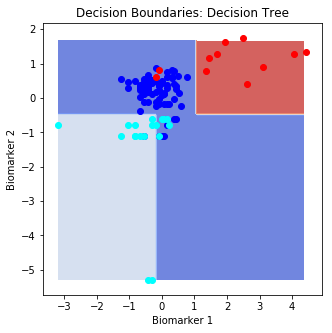

In [42]:
# Question 3.3
fig, ax_arr = plt.subplots(1,1, figsize = (5,5))
plot_decision_boundary(x_train_norm.as_matrix(), y_train.as_matrix(), dec_tree, "Decision Boundaries: Decision Tree", ax_arr)

*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1) Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

**At tree depth of $6$, the decision tree model achieves nearly perfect accuracy on the training set. This means that at and beyond this depth, the model is overfitting as it is trying to classify correctly almost every single data point. As we increase the depth of the tree, the accuracy on the test set starts decreasing already at depth 4.**

2) Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

**The optimal tree depth found using CV was $2$. The accuracy achieved with this decision tree was 92.15% on the training set and 87.61% on the test set ** 

**Other models:**


|  Model | Train Accuracy | Test Accuracy
|---|---|---|
|  Multinomial Logistic Regression |  89.21% | 88.50%  | 
|   OvR Logistic Regression|  86.27% | 85.84 %  |    
|  Multinomial Logistic Regression - quadratic |  88.23 % |  88.49% | 
| LDA | 87.25% | 83.19% |
|QDA    | 87.25% | 84.96% |
|kNN (n=3) | 94.11%  | 88.50%|
| Decision Tree depth 2| 92.15% | 87.61 %|

**Decision Tree outperformed LDA and QDA (likely because the underlying data was not normally distributed which is an assumption in LDA/QDA). On the other hand, better performance was achieved with multinomial logistic regression and with kNN (n=3).**


3) Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

**The decision tree model allows us to create classification boundaries which cannot be expressed as a classical function (e.g., vertical lines in the graph above violate the  one-to-one mapping property of functions: f(x) != y). Also, the decision tree boundary is easier to interpret mathematically.**

4) Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient. 

**Decision tree model : Look at Biomarker_2 Is it less than or equal to -0.49? If no, class 1 - normal. If yes, look at Biomarker_1. Is it less than -0.1468? If yes - class 2 - hyperthyroid, else hypothyroid class 3.**

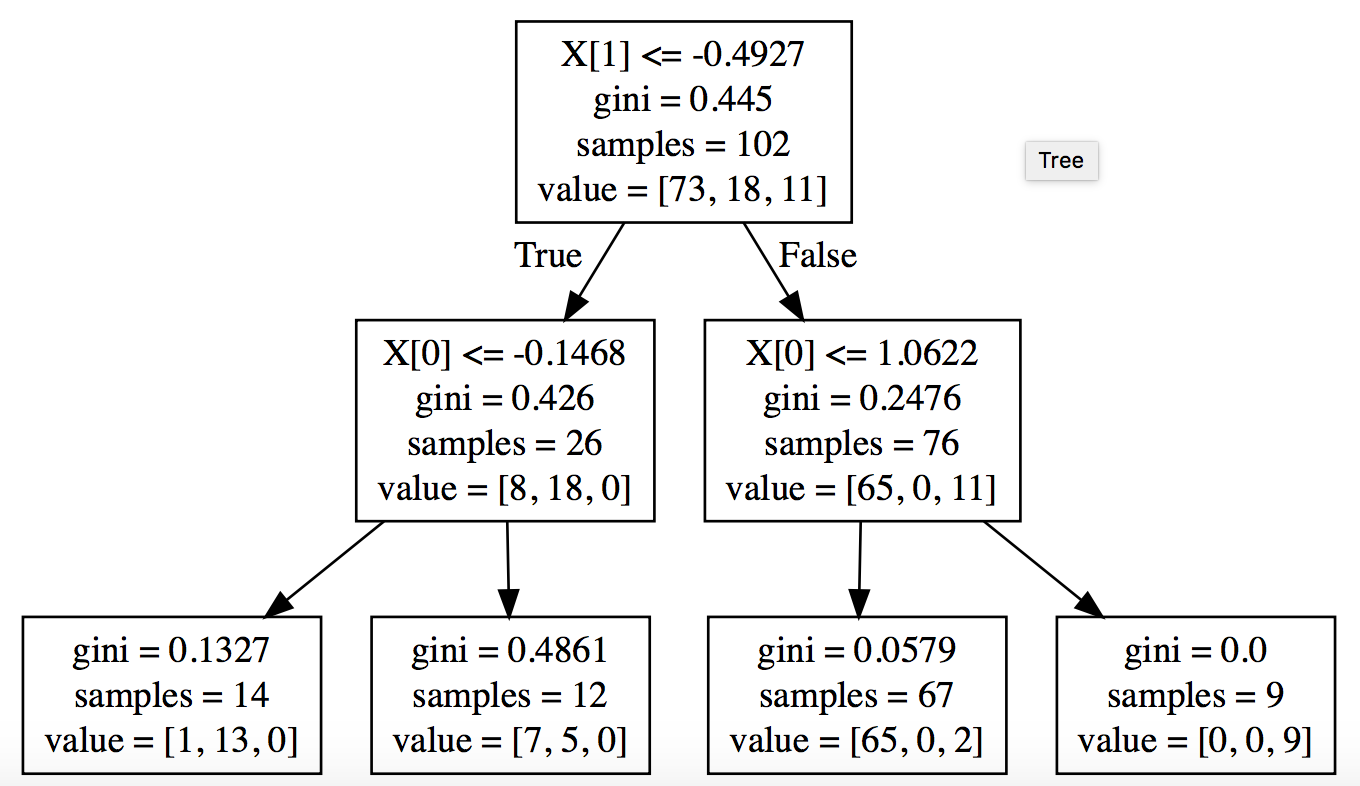

In [43]:
from IPython.display import Image
Image(filename='Decision Tree HW7.png',width=500)

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1) Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

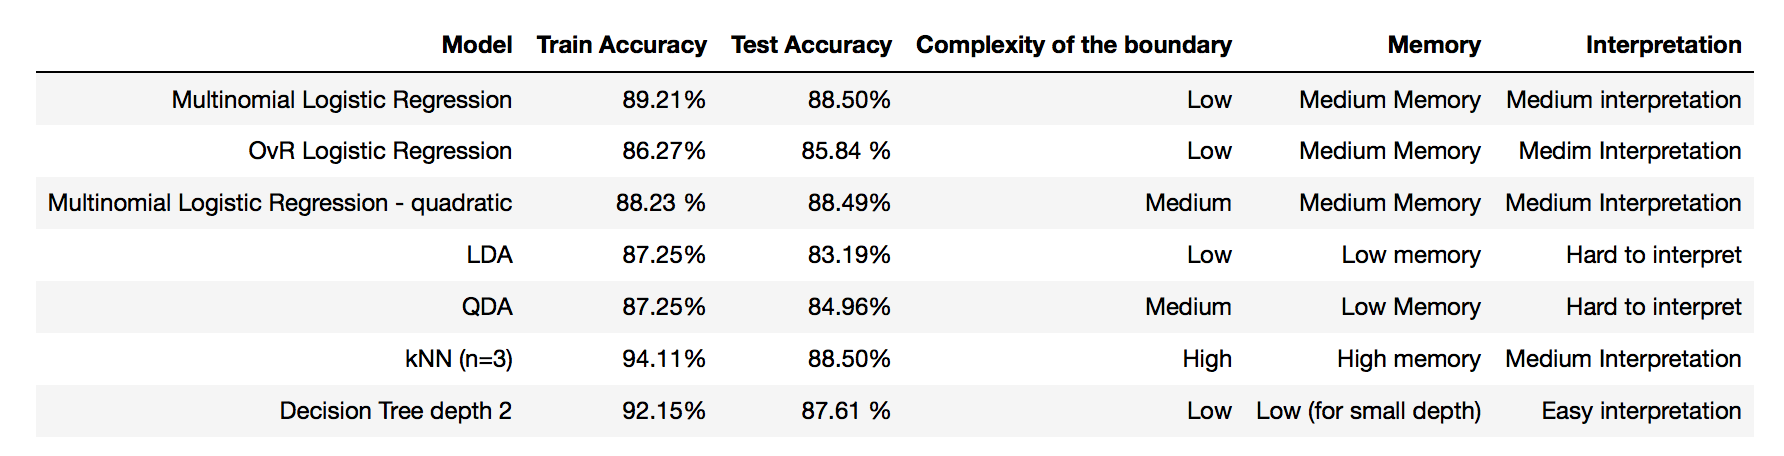

In [51]:
Image(filename='Model Comparisons.png',width=1000)


**The decision which classification model is best to use depends on the underlying data. In general, when we have data which are multivariate normally distributed among classifiers, LDA/QDA is the best to use given its lower memory and complexity requirements. However, if the data is not MVN, we can use logistic regression which does not need MVN data to work. In terms of interpretability, for logistic regression we can calculate probability of outcome for each classifier, which is more understandable than the LDA method, which lowers the dimensionality of the data**

**kNN takes the most memory as one needs to calculate the Euclidean distance for each data point of $k$ nearest neighbours for classification but has the best accuracy when the classification boundary is highly non-linear.**

2) If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

**I would likely choose the decision tree, since it is the easiest to interpret and we can visualize how the model makes the classification decisions**

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

**Accuracy of the OvR logit regression on the test set: 85.84%, patients in the test set n = 113. Total cost = 113*(1-0.8485)*5000/113 = $758$/patient or $85,597$**

**Abstain when none of the 3 classification probabilities is over 95%??**

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [44]:
import warnings; warnings.simplefilter('ignore')
### MODEL ####

### Hospital Management : Input params here ###
#Cutoff to abstain - example: What-if we cut off observations where NONE of the classifications has over threshold probability
cutoff_proba = 0.93
#Cost params
cost_to_abstain = 1000
cost_of_misclassification = 5000
################

costs, full_data = [], []
print("TRAINING SET")
for certainty_threshold in np.linspace(0.5,1,50):
    abstained_patients = np.all(ovr_model.predict_proba(x_train_norm)<certainty_threshold,axis=1)
    abstained_number = sum(abstained_patients)
    
    not_abstained_number = x_train_norm[~abstained_patients].shape[0]
    if not_abstained_number == 0: # All patients are abstaining so everything past thisi threshold is meaningless.
        break
    
    correct_number = np.round(not_abstained_number * cross_val_score(ovr_model, x_train_norm[~abstained_patients], y_train[~abstained_patients]).mean())
    
    misclassified_number =  x_train_norm[~abstained_patients].shape[0] - correct_number

    #cost associated with abstaining:
    abstain_cost=abstained_number*cost_to_abstain
    misclassified_cost=misclassified_number*cost_of_misclassification
    total_cost = abstain_cost+misclassified_cost
    
    print("|THRESH:{:2.2f}|Correct:{}.  Misclass:{}.  Abstained:{}.  Misclass/Abstain Cost:{} + {} = {}".format(certainty_threshold,
                                                                                                correct_number, 
                                                                                                misclassified_number, 
                                                                                                abstained_number, 
                                                                                                misclassified_cost, 
                                                                                                abstain_cost, 
                                                                                                total_cost))
    costs.append([total_cost, certainty_threshold])
    full_data.append([certainty_threshold,correct_number,misclassified_number,abstained_number,misclassified_cost,abstain_cost,total_cost])
                                                                                     
                                                                                                 
                                                                                                 
                                                                                                 
                                                                                                


# Finally, produce test performance at best training threshold
print("\n\n")
print("TEST SET")
costs = np.array(costs)
best_threshold_index = np.argmin(costs[:,0])
best_threshold = costs[best_threshold_index,1]

print(best_threshold)

abstained_patients = np.all(ovr_model.predict_proba(x_test_norm)<best_threshold,axis=1)
abstained_number = sum(abstained_patients)

not_abstained_number = x_test_norm[~abstained_patients].shape[0]

correct_number = np.round(not_abstained_number * ovr_model.score(x_test_norm[~abstained_patients], y_test[~abstained_patients]))

misclassified_number =  x_test_norm[~abstained_patients].shape[0] - correct_number

#cost associated with abstaining:
abstain_cost=abstained_number*cost_to_abstain
misclassified_cost=misclassified_number*cost_of_misclassification
total_cost = abstain_cost+misclassified_cost

print("|THRESH:{:2.2f}|Correct:{}.  Misclass:{}.  Abstained:{}.  Misclass/Abstain Cost:{} + {} = {}".format(best_threshold,
                                                                                            correct_number, 
                                                                                            misclassified_number, 
                                                                                            abstained_number, 
                                                                                            misclassified_cost, 
                                                                                            abstain_cost, 
                                                                                            total_cost))


TRAINING SET
|THRESH:0.50|Correct:85.0.  Misclass:17.0.  Abstained:0.  Misclass/Abstain Cost:85000.0 + 0 = 85000.0
|THRESH:0.51|Correct:83.0.  Misclass:16.0.  Abstained:3.  Misclass/Abstain Cost:80000.0 + 3000 = 83000.0
|THRESH:0.52|Correct:83.0.  Misclass:16.0.  Abstained:3.  Misclass/Abstain Cost:80000.0 + 3000 = 83000.0
|THRESH:0.53|Correct:82.0.  Misclass:16.0.  Abstained:4.  Misclass/Abstain Cost:80000.0 + 4000 = 84000.0
|THRESH:0.54|Correct:82.0.  Misclass:15.0.  Abstained:5.  Misclass/Abstain Cost:75000.0 + 5000 = 80000.0
|THRESH:0.55|Correct:80.0.  Misclass:16.0.  Abstained:6.  Misclass/Abstain Cost:80000.0 + 6000 = 86000.0
|THRESH:0.56|Correct:80.0.  Misclass:16.0.  Abstained:6.  Misclass/Abstain Cost:80000.0 + 6000 = 86000.0
|THRESH:0.57|Correct:81.0.  Misclass:14.0.  Abstained:7.  Misclass/Abstain Cost:70000.0 + 7000 = 77000.0
|THRESH:0.58|Correct:82.0.  Misclass:9.0.  Abstained:11.  Misclass/Abstain Cost:45000.0 + 11000 = 56000.0
|THRESH:0.59|Correct:75.0.  Misclass:11.0.  

In [46]:
import csv 
with open('data_diagnosis.csv', 'w') as csvfile:
    fieldnames = ['Certainty Threshold', 'Correct Number','Misclassified Number','Abstained Number','Misclassified cost','Abstain Cost','Total Cost']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    #[certainty_threshold,correct_number,misclassified_number,abstained_number,misclassified_cost,abstain_cost,total_cost]
    for i in full_data[::2]:
        writer.writerow({'Certainty Threshold': i[0], 'Correct Number': i[1], 'Misclassified Number':i[2], 'Abstained Number': i[3], 'Misclassified cost':i[4],'Abstain Cost':i[5],'Total Cost':i[6]})
    writer.writerow({'Certainty Threshold': best_threshold, 'Correct Number': correct_number, 'Misclassified Number':misclassified_number, 'Abstained Number': abstained_number, 'Misclassified cost':misclassified_cost,'Abstain Cost':abstain_cost,'Total Cost':total_cost})